In [118]:
import bt
import ffn
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import pandas as pd

In [119]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [120]:
start='2021-1-1'
end='2022-1-1'                  

In [121]:
#Get the data
crypto_data = yf.download("BTC-USD", start, end)    
#Drop some columns
col=['High', 'Low', 'Open', 'Volume', 'Adj Close']
crypto_data.drop(columns=col, axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


## 1-Mean-reversion strategy

In [122]:
#Creating a RSI mean reversion strategy
crypto_rsi=talib.RSI(crypto_data['Close']).to_frame()

In [123]:
#Dataframe structure of rsi
signal=crypto_rsi.copy()
signal[crypto_rsi.isnull()]=0


#Create the signal
signal[crypto_rsi<30]=1
signal[crypto_rsi>70]=-1
signal[(crypto_rsi>=30) & (crypto_rsi<=70)]=0

In [124]:
#Merge data

combined_df=bt.merge(signal, crypto_data)
combined_df.columns=['Signal', 'Price']

<AxesSubplot:xlabel='Date'>

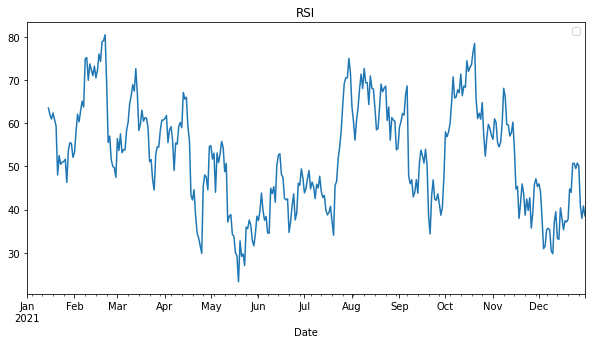

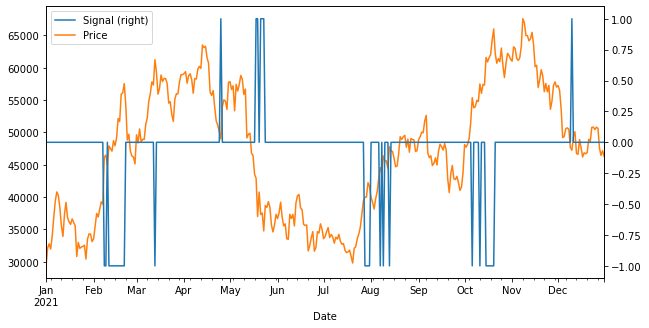

In [125]:
crypto_rsi.plot()
_=plt.legend("")
_=plt.title("RSI")



combined_df.plot(secondary_y=['Signal'])

In [126]:
#Define the strategy
signal.columns=['Close']

bt_strategy=bt.Strategy('RSI_Mean Reversion',
                       [bt.algos.WeighTarget(signal),
                       bt.algos.Rebalance()])

In [127]:
#Create the backtest and run it
bt_backtest=bt.Backtest(bt_strategy, crypto_data)

In [128]:
bt_results=bt.run(bt_backtest)

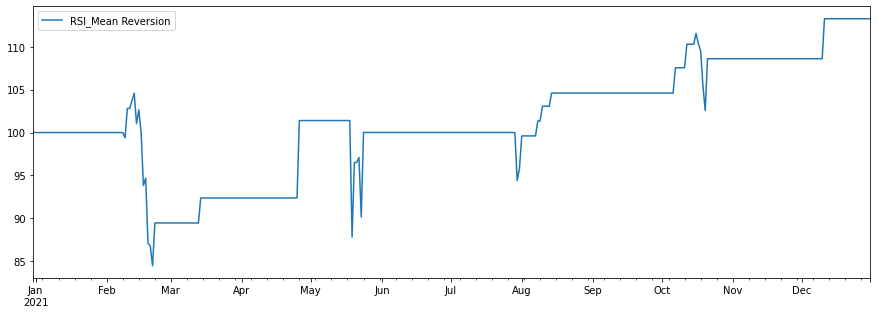

In [129]:
bt_results.plot(title='Backtest result')
_=plt.title("")

In [130]:
bt_results.stats

,RSI_Mean Reversion
start,2020-12-31 00:00:00+00:00
end,2021-12-31 00:00:00+00:00
rf,0.0
total_return,0.13267
cagr,0.132767
max_drawdown,-0.192443
calmar,0.6899
mtd,0.042929
three_month,0.08287
six_month,0.132576


#### So, with the mean reversion strategy the total return would have became negative; about 1% for the entire period. Maybe treating the "trend as your friend" may have turned out different results. Let's try that.

## 2-Trend following strategy : MA crossover strategy

### Logic: 
* Long signal: the short term EMA crosses above the long term EMA; price is picking at momentum
* Short signal: the short term EMA crosses below the long term EMA; prices is loosing momentum


In [131]:
# Calculating the indicators

EMA_short=talib.EMA(crypto_data['Close'],
                   timeperiod=10).to_frame()

EMA_long=talib.EMA(crypto_data['Close'],
                   timeperiod=40).to_frame()


In [132]:
# Creating the signal datafram
signal_trend=EMA_long.copy()
signal_trend[EMA_long.isnull()]=0

#Construct the signal

signal_trend[EMA_short>EMA_long]=1
signal_trend[EMA_short<EMA_long]=-1


<AxesSubplot:xlabel='Date'>

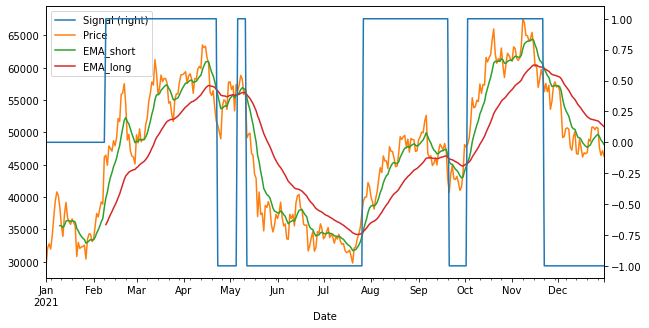

In [133]:
#Plot the signals, prices and MAs

combined_df_trend=bt.merge(signal_trend, crypto_data, EMA_short, EMA_long)
combined_df_trend.columns=['Signal', 'Price', 'EMA_short', 'EMA_long']

combined_df_trend.plot(secondary_y=['Signal'])

In [134]:
#Defining the strategy
signal_trend.columns=['Close']
bt_strategy_trend=bt.Strategy('EMA Crossover',
                             [bt.algos.WeighTarget(signal_trend),
                             bt.algos.Rebalance()])
bt_backtest_trend=bt.Backtest(bt_strategy_trend, crypto_data)
bt_results_trend=bt.run(bt_backtest_trend)

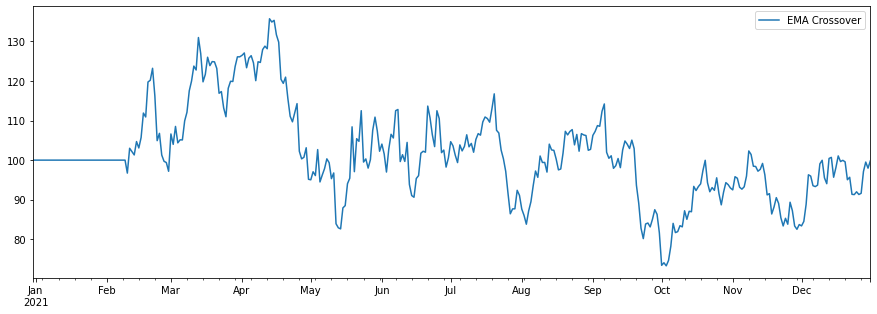

In [137]:
#Plotting the results

bt_results_trend.plot(title='Backtest results')
_=plt.title("")

In [136]:
bt_results_trend.stats

,EMA Crossover
start,2020-12-31 00:00:00+00:00
end,2021-12-31 00:00:00+00:00
rf,0.0
total_return,-0.002026
cagr,-0.002027
max_drawdown,-0.460255
calmar,-0.004404
mtd,0.192207
three_month,0.222693
six_month,-0.007521


This strategy looks better. But, it looks not as profitable as one might expect. What if we just had bought btc and do nohting until sometime long
in the future, say, 2022. 